In [ ]:
""" 
Project: CSC 790
Team: 01
Authors: Rafail Islam, Yeboah Dacosta, Shashi Khanal
Project: Deep Convolutional Generative Adversarial Network for generating synthetic images of MNIST dataset
"""

In [1]:
# Imports library

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Input, Flatten,Reshape, LeakyReLU,Activation, Dropout
import os
import time


In [9]:

noise_dim = 100
num_examples_to_generate = 16

buffer_size = 60000
batch_size = 200
noise_dim = 100
sample_noise_vector = tf.random.normal([16, 100])

In [3]:
# Load & preprocess dataset

def load_data( buffer_size=60000, batch_size = 64):
    """ This function loads and preprocesses data, then return train dataset
    """
    # load dataset
    (train_images, train_labels), (test_images, _) = tf.keras.datasets.mnist.load_data()
    
    # Reshape image into singel channel
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
    
    # Normalize image
    # Normalize the images to [-1, 1]
    train_images = (train_images - 127.5) / 127.5 
    test_images = (test_images - 127.5) / 127.5 
    
    # slip data set by batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
    
    return train_dataset,train_images,test_images
train_dataset,x_train,x_test = load_data(buffer_size=buffer_size, batch_size=batch_size)
print(x_train.shape)
print(x_test.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# # model sub classing for autoencoder

# class build_autoencoder(Model):
#     def __init__(self, latent_dim):
#         super(build_autoencoder, self).__init__()
        
#         self.latent_dim = latent_dim   
        
#         self.encoder = tf.keras.Sequential([
#             Flatten(input_shape = (28, 28,1)),
#             Dense(512),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(256),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(128),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(64),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(latent_dim),
#             LeakyReLU()
#         ])
#         self.decoder = tf.keras.Sequential([
#             Dense(64, input_shape = (latent_dim,)),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(128),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(256),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(512),
#             LeakyReLU(),
#             Dropout(0.5),
#             Dense(784),
#             Activation("tanh"),
#             Reshape((28, 28))
#         ])
#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded
# autoencoder = build_autoencoder(100) 
# autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
# autoencoder.fit(x_train, x_train,
#                 epochs=100,
#                 shuffle=True,
#                 validation_data=(x_test, x_test)
#                )



In [5]:

# #decoded_imgs = autoencoder.decoder(sample_noise_vector).numpy()
# #encoded_lat = autoencoder.encoder(decoded_imgs).numpy()
# gen_imgs = autoencoder.decoder(sample_noise_vector).numpy()
# #gen_imgs = saved_generator(sample_noise_vector, training=False) # training = False to avoid updating weights
# print(gen_imgs.shape)
# print("-------------")
# #fig = plt.figure(figsize=(10,10))

# fig = plt.figure(figsize=(4,4))

# for i in range(gen_imgs.shape[0]):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(gen_imgs[i] , cmap='gray')
#     plt.axis('off')

# #plt.savefig('./Project_1/images/image_at_epoch_{:04d}.png'.format(epoch+1))
# plt.show()

# Save Auto Encoder Model

In [6]:
#autoencoder.save("./DCGAN-with-AutoEncoder/my_model1")

# Load pre-trained AutoEncoder

In [7]:
saved_autoencoder = tf.keras.models.load_model("./DCGAN-with-AutoEncoder/my_model1")

(16, 28, 28)
-------------


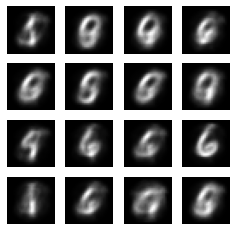

In [10]:

decoded_imgs = saved_autoencoder.decoder(sample_noise_vector).numpy()
encoded_lat = saved_autoencoder.encoder(decoded_imgs).numpy()
gen_imgs = saved_autoencoder.decoder(sample_noise_vector).numpy()
#gen_imgs = saved_generator(sample_noise_vector, training=False) # training = False to avoid updating weights
print(gen_imgs.shape)
print("-------------")
#fig = plt.figure(figsize=(10,10))

fig = plt.figure(figsize=(4,4))

for i in range(gen_imgs.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(gen_imgs[i]  * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

#plt.savefig('./Project_1/images/image_at_epoch_{:04d}.png'.format(epoch+1))
plt.show()

In [11]:
# Build Generator Model
def build_generator(noise_dim=100):
    """ Builds generator architecture and return the model
    """
    
    # input layer sahpe of noise_dim #Gaussian random numbers
    inputs = Input(shape=(noise_dim,) )
    
    dense_l1 = layers.Dense(256*7*7,activation='relu')(inputs) # start with low regulation image 7*7
    bn1 = layers.BatchNormalization() (dense_l1)
    lkr1 = layers.LeakyReLU()(bn1)
    # Reshape output
    rh1 = layers.Reshape((7, 7, 256))(lkr1)
    
    # Gradually upsampling
    # Conv2DTranspose layer 1
    cdt1 = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(rh1)
    bn2 = layers.BatchNormalization() (cdt1)
    lkr2 = layers.LeakyReLU()(bn2)
    # Conv2DTranspose layer 2
    cdt2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(lkr2)
    bn3 = layers.BatchNormalization() (cdt2)
    lkr3 = layers.LeakyReLU()(bn3)
    
    # Conv2DTranspose layer 3
    cdt3 = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(lkr3)
    
    
    model = Model(inputs=inputs,outputs= cdt3)
    
    return model

In [12]:
# Build Discriminator
def build_discriminator():
    """Builds discriminator architecture and returns model
    """
    
    inputs = Input(shape=(28,28,1,))
    
    convl1 = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    lk1 = layers.LeakyReLU()(convl1)
    dp1 = layers.Dropout(0.3)(lk1)
    
    convl2 = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(dp1)
    lk2 = layers.LeakyReLU()(convl2)
    dp2 = layers.Dropout(0.3)(lk2)


    ftl1 = layers.Flatten()(dp2)
    outputs = layers.Dense(1)(ftl1)
    model = Model(inputs=inputs,outputs=outputs)
    return model

In [13]:
# 
def discriminator_loss(real_output, fake_output,cross_entropy):
    """ Calculates loss for discriminator model and returns it
    """
    # Loss for real images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Loss for fake generated images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [14]:
def generator_loss(fake_output,cross_entropy):
    """ Calculates loss for generator model and returns it
    """
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    
    return gen_loss

In [15]:


@tf.function
def train(images,encoded_latient,generator,discriminator,generator_optimizer,discriminator_optimizer,cross_entropy):
    """ This function takes batch of train images and train and update both of the generator and discriminator model
    """
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # gernerator model generate fake images
        gen_imgs = generator(encoded_latient, training=True)
        
        # Discriminator classify real image and fake generated images
        real_outputs = discriminator(images, training=True)
        fake_outputs = discriminator(gen_imgs, training=True)
        
        # calculating loss ofr generator and dicriminator
        gen_loss = generator_loss(fake_outputs,cross_entropy)
        dis_loss = discriminator_loss(real_outputs, fake_outputs,cross_entropy)

    # get gradients
    gradient_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_dis = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    # apply gradients
    generator_optimizer.apply_gradients(zip(gradient_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_dis, discriminator.trainable_variables))
    
    return gen_loss, dis_loss*0.5

In [16]:
# Generate images with trained generator model
def generate_image(generator,sample_noise_vector,epoch):
    
    # generate images
    gen_imgs = generator(sample_noise_vector, training=False) # training = False to avoid updating weights

    fig = plt.figure(figsize=(4,4))

    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./DCGAN-with-AutoEncoder/images/image_at_epoch_{:04d}.png'.format(epoch+1))
    plt.show()

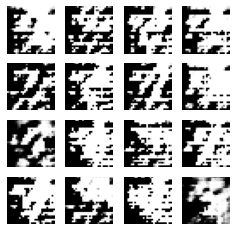

Epoch 10,	Generator loss 1399.60,	Discriminator loss: 67.04


In [18]:
# --- main block
EPOCHS = 100

generator = build_generator(100)

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

discriminator = build_discriminator()
img_label = discriminator(generated_image)

generator_optimizer = tf.keras.optimizers.Adam(0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.001)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Random sample for generation fake image over the course of training model
sample_noise_vector = tf.random.normal([num_examples_to_generate, noise_dim])

#train_dataset = load_data(buffer_size=buffer_size, batch_size=batch_size)

hist_gen_loss = []
hist_dis_loss = []
for epoch in range (EPOCHS):
    gen_loss = 0
    dis_loss = 0
    c = 0
    for batch_imgs in train_dataset:
        c +=1
        # generating random noise 
        noise_vector = tf.random.normal([batch_size, noise_dim])

        # Using pre-trained autoencoder 
        decoded_imgs = saved_autoencoder.decoder(noise_vector).numpy()
        encoded_latient = saved_autoencoder.encoder(decoded_imgs).numpy()
#         print(type(encoded_latient))
#         print(encoded_latient.shape)
#         print(encoded_latient.dtype)
        loss1, loss2 = train(batch_imgs,encoded_latient,generator,discriminator, generator_optimizer,discriminator_optimizer,cross_entropy)
        
        #print(loss1.numpy())
        #print(loss2.numpy())
        
        gen_loss += loss1.numpy()
        dis_loss += loss2.numpy()
        
        # generate few sample synthetic image while traing
        # and save it
    display.clear_output(wait=True)
        #print('Generator loss %.2f,\tDiscriminator loss: %.2f'%(loss1,loss2))
    if epoch % 5 == 0:
        generate_image(generator,sample_noise_vector,epoch)
    #generate_image(generator,sample_noise_vector,epoch)
        
    hist_gen_loss.append(gen_loss/c) # average loss per epoch
    hist_dis_loss.append(dis_loss/c)
        
    print('Epoch %d,\tGenerator loss %.2f,\tDiscriminator loss: %.2f'%(epoch+1,gen_loss,dis_loss))
            

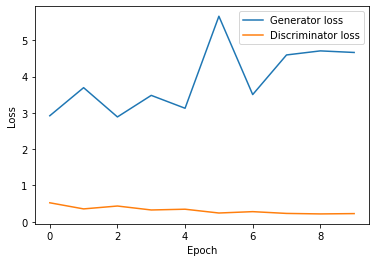

In [19]:
plt.plot(range(EPOCHS),hist_gen_loss,label='Generator loss')
plt.plot(range(EPOCHS),hist_dis_loss,label='Discriminator loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss-vs-Epoch_DCGAN-with-AutoEncoder")
plt.show()

# Save Model

In [ ]:
generator.save("./DCGAN-with-AutoEncoder/GenModel1")

In [ ]:
saved_generator = tf.keras.models.load_model("./DCGAN-with-AutoEncoder/GenModel1")

In [ ]:
sample_noise_vector = tf.random.normal([10, 100])
gen_imgs = saved_generator(sample_noise_vector, training=False) # training = False to avoid updating weights

fig = plt.figure(figsize=(10,10))

for i in range(gen_imgs.shape[0]):
    display.clear_output(wait=True)
    plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.title("gen_image_"+str(i+1))

    plt.savefig('./DCGAN-with-AutoEncoder/generated images/gen_image_{:05d}.png'.format(i+1))
    plt.show()

In [ ]:
# def build_encoder(latent_dim):
#     inputs = Input(shape=(28,28))
#     hl = Flatten()(inputs)
#     hl = Dense(512)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(400)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(300)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(200)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(latent_dim)(hl)
#     outputs = LR()(hl)
#     model = Model(inputs=inputs,outputs=outputs)
#     return model
# def build_decoder(latent_dim):
#     inputs =  Input(shape=(latent_dim,))
#     hl = Dense(64)(inputs)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(128)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(256)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(512)(hl)
#     hl = LR()(hl)
#     hl = Dropout(0.5)(hl)
#     hl = Dense(784)(hl)
#     hl = Activation("sigmoid")(hl)
#     outputs = Reshape((28, 28)) (hl)
#     model = Model(inputs=inputs, outputs=outputs)
#     return model